# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="/home/adebraine/Documents/Personal Projects/Git Repos/RLND-Projects/Collaboration and Competition/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [5]:
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# from ddpg_agent import Agent
import time
plt.ion()

In [6]:
# Watch changes and reload automatically
%load_ext autoreload
%autoreload 2

from ddpg_agent import Agent
seed = 12345

agents = [Agent(state_size, action_size, n_agents=1, seed=1) for i in range(num_agents)]

In [10]:
def train(agents, n_episodes=6000, goal=0.5, episodes_cycle=100, isnoise=True):
    scores_window = deque(maxlen=episodes_cycle)
    scores_all = []
    best_scores = []
    best_score = -np.inf
    best_episode = 0

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment
        states = np.reshape(env_info.vector_observations, (1,num_agents*state_size)) # flatten states
        for agent in agents:
            agent.reset()
        scores = np.zeros(num_agents)
        while True:
            actions = actions = [agent.act(states, isnoise) for agent in agents]
            actions = np.reshape(actions, (1, num_agents*action_size))
            env_info = env.step(actions)[brain_name]           # send both agents' actions to the environment
            next_states = np.reshape(env_info.vector_observations, (1, num_agents*state_size)) # flatten next states
            rewards = env_info.rewards                         # get rewards
            done = env_info.local_done                         # see if the episode finished
            for i, agent in enumerate(agents):
                agent.step(states, actions, rewards[i], next_states, done, i)
            scores += np.max(rewards)                          # update scores with best reward
            states = next_states                               # roll over states to next time step
            if np.any(done):                                   # exit loop if episode finished
                break

        ep_best_score = np.max(scores)                         # record best score for episode
        scores_window.append(ep_best_score)                    # add score to recent scores
        scores_all.append(ep_best_score)                       # add score to histor of all scores
        best_scores.append(np.mean(scores_window))          # recalculate moving average

        # save best score
        if ep_best_score > best_score:
            best_score = ep_best_score
            best_episode = i_episode

        # print results
        if i_episode % episodes_cycle == 0:
            print('Episodes {:0>4d}-{:0>4d}\tScores: {:.3f}'.format(
                i_episode-episodes_cycle, i_episode, best_scores[-1]))

        # determine if environment is solved and keep best performing models
        if best_scores[-1] >= goal:
            print('--- Environment solved in {:d} episodes! \
            \n--- Scores: {:.3f} over past {:d} episodes'.format(
                i_episode-episodes_cycle, best_scores[-1], episodes_cycle))
            # save weights
            for num, agent in enumerate(agents):
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_{}.pth'.format(num))
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_{}.pth'.format(num))
            np.save('scores.npy', best_scores)
            break
        else:
            continue
    
    return best_scores, best_score, best_episode

In [11]:
best_scores, best_score, best_episode = train(agents,
                                              n_episodes=6000,
                                              goal=0.5,
                                              episodes_cycle=100,
                                              isnoise=True)

Episodes 0000-0100	Scores: 0.018
Episodes 0100-0200	Scores: 0.047
Episodes 0200-0300	Scores: 0.034
Episodes 0300-0400	Scores: 0.044
Episodes 0400-0500	Scores: 0.057
Episodes 0500-0600	Scores: 0.043
Episodes 0600-0700	Scores: 0.071
Episodes 0700-0800	Scores: 0.051
Episodes 0800-0900	Scores: 0.081
Episodes 0900-1000	Scores: 0.108
Episodes 1000-1100	Scores: 0.105
Episodes 1100-1200	Scores: 0.118
Episodes 1200-1300	Scores: 0.134
Episodes 1300-1400	Scores: 0.143
Episodes 1400-1500	Scores: 0.163
Episodes 1500-1600	Scores: 0.198
Episodes 1600-1700	Scores: 0.232
--- Environment solved in 1676 episodes!             
--- Scores: 0.510 over past 100 episodes


([0.0,
  0.0,
  0.0,
  0.0,
  0.020000000298023225,
  0.033333333830038704,
  0.028571428997176036,
  0.02500000037252903,
  0.022222222553359136,
  0.020000000298023225,
  0.018181818452748386,
  0.016666666915019352,
  0.015384615613864018,
  0.014285714498588018,
  0.013333333532015483,
  0.012500000186264515,
  0.01176470605766072,
  0.011111111276679568,
  0.010526315946328012,
  0.010000000149011612,
  0.009523809665725344,
  0.009090909226374193,
  0.008695652303488358,
  0.008333333457509676,
  0.00800000011920929,
  0.007692307806932009,
  0.007407407517786379,
  0.007142857249294009,
  0.01034482774035684,
  0.010000000149011612,
  0.009677419499043495,
  0.009375000139698386,
  0.009090909226374193,
  0.00882352954324554,
  0.008571428699152811,
  0.008333333457509676,
  0.010810810971904445,
  0.01578947391949202,
  0.015384615613864018,
  0.015000000223517418,
  0.017073170986117388,
  0.016666666915019352,
  0.016279070010018902,
  0.01590909114615484,
  0.015555555787351

In [7]:
scores = np.load('scores.npy')

def plot_scores(scores, order):
    plt.plot(np.arange(len(scores)), scores)
    sns.regplot(x=np.arange(len(scores)), y=scores, order=order, scatter=False)
    plt.xlabel('Number of Episodes')
    plt.ylabel('Score')
    plt.savefig('scores.png')
    plt.show()

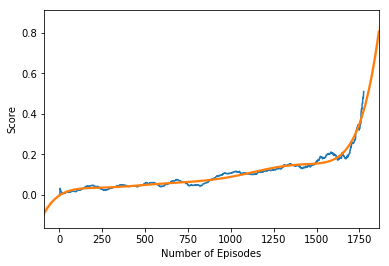

In [8]:
plot_scores(scores, order=7)

In [9]:
for num, agent in enumerate(agents):
    agent.actor_local.load_state_dict(torch.load('checkpoint_actor_{}.pth'.format(num)))
    agent.critic_local.load_state_dict(torch.load('checkpoint_critic_{}.pth'.format(num)))

When finished, you can close the environment.

In [10]:
env_info = env.reset(train_mode=0)[brain_name] 
states = np.reshape(env_info.vector_observations,
                    (1,num_agents*state_size))
scores = np.zeros(num_agents)
while True:
    actions = actions = [agent.act(states, 0) for agent in agents]
    actions = np.reshape(actions, (1, num_agents*action_size))
    env_info = env.step(actions)[brain_name]
    next_states = np.reshape(env_info.vector_observations,
                             (1, num_agents*state_size))
    rewards = env_info.rewards
    done = env_info.local_done
    scores += np.max(rewards)
    states = next_states
    if np.any(done):
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 1.600000023841858


In [14]:
env.close()

A previous run yielded the following results
<img src='scores2.png'>